<a href="https://colab.research.google.com/github/collab00/notebooks/blob/main/trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance talib-binary pandas_ta

In [ ]:
NIFTY50 = ["GRASIM", "ONGC", "HINDALCO", "SHREECEM", "BRITANNIA", "TATACONSUM", "HDFCLIFE", "ASIANPAINT", "NESTLEIND",
           "ULTRACEMCO", "COALINDIA", "WIPRO", "HINDUNILVR", "TCS", "ICICIBANK", "SBILIFE", "TECHM", "IOC", "UPL",
           "DIVISLAB", "MARUTI", "RELIANCE", "BPCL", "TATAMOTORS", "HDFCBANK", "EICHERMOT", "HCLTECH", "KOTAKBANK",
           "HEROMOTOCO", "INDUSINDBK", "ITC", "AXISBANK", "INFY", "SUNPHARMA", "JSWSTEEL", "SBIN", "TATASTEEL", "POWERGRID",
           "ADANIPORTS", "NTPC", "DRREDDY", "CIPLA", "BAJAJ-AUTO", "TITAN", "LT", "HDFC", "BHARTIARTL", "M&M",
           "BAJFINANCE", "BAJAJFINSV"]

In [56]:
from yfinance import Ticker
import pandas_ta as ta
import talib

def create_df(symbol, start):
    df = Ticker(symbol + '.NS').history(start=start, back_adjust=True)
     
    rolling_high = df['High'].rolling(21, center=True).mean()
    rolling_high_pct_change = rolling_high.pct_change().rolling(14, center=True).mean()
    downtrend_threshold = rolling_high_pct_change.std()
    df['downtrend'] = rolling_high_pct_change.apply(lambda x : 1 if x < -downtrend_threshold else 0).rolling(7,center=True).mean().apply(lambda x : 1 if x > 0 else 0)
    rolling_low = df["Low"].rolling(14, center=True).mean()
    rolling_low_pct_change = rolling_low.pct_change().rolling(7, center=True).mean()
    uptrend_threshold = rolling_low_pct_change.std()
    df['uptrend'] = rolling_low_pct_change.apply(lambda x : 1 if x > uptrend_threshold else 0).rolling(7,center=True).mean().apply(lambda x : 1 if x > 0 else 0)
    df['notrend'] = 1 - df['uptrend'] - df['downtrend']

    for l, m in [(7,1), (7,2), (7,3), (7,4)]:
        df[f'st{l}{m}'] = (ta.supertrend(df['High'], df['Low'], df['Close'], l, m)[f'SUPERTd_{l}_{m}.0'] + 1) // 2
    candle_patterns = ["CDL3BLACKCROWS", "CDL3INSIDE", "CDL3LINESTRIKE", "CDLABANDONEDBABY", "CDLBREAKAWAY", "CDLEVENINGSTAR",
                      "CDLINNECK", "CDLINVERTEDHAMMER", "CDLMATCHINGLOW", "CDLMORNINGSTAR", "CDLPIERCING",
                      "CDLSTICKSANDWICH", "CDLTASUKIGAP", "CDLTHRUSTING"]

    for pattern in candle_patterns:
        pattern_data = getattr(talib, pattern)(df['Open'], df['High'], df['Low'], df['Close'])
        df[pattern + '_Bear'] = pattern_data.apply(lambda x: 1 if x < 0 else 0)
        df[pattern + '_Bull'] = pattern_data.apply(lambda x: 1 if x > 0 else 0)

    return df

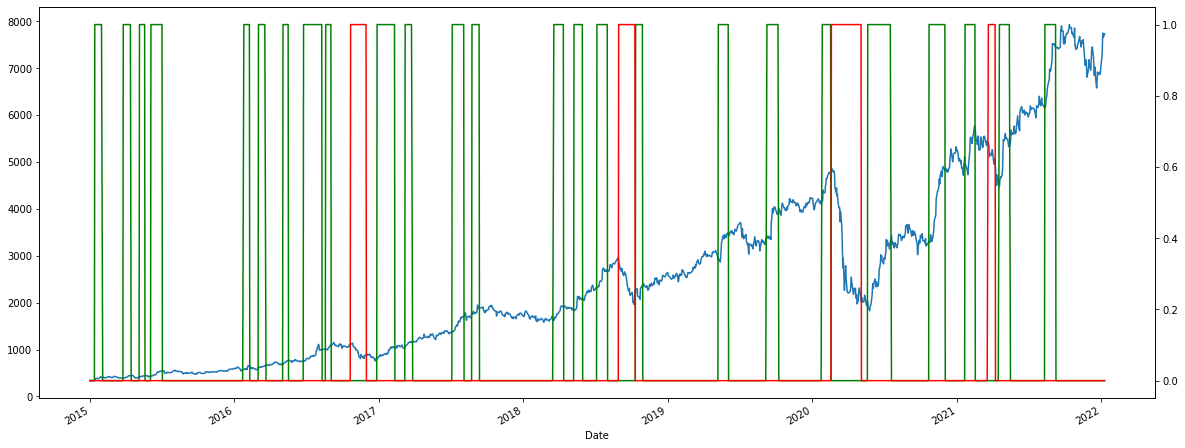

In [57]:
df = create_df('BAJFINANCE', '2015-01-01')

ax = df['Close'].plot(figsize=(20,8))
ax2 = ax.twinx()
df['uptrend'].plot(ax=ax2, color='g')
df['downtrend'].plot(ax=ax2, color='r')

In [48]:
from yfinance import Ticker

def get_data(symbol, start):
    df = Ticker(symbol + '.NS').history(start=start, back_adjust=True)
    return df
     
df = get_data('BAJFINANCE', '2015-01-01')

In [49]:
df['delta'] = df['Close'].diff(1)
df.dropna(inplace=True)

In [51]:
sp = np.fft.fft(df['delta'].values)
sp

array([ 7387.23150635-2.38742359e-12j,  1670.53114397+1.75402398e+03j,
        1695.45163941+2.81078560e+03j, ...,
       -1037.08060591-3.47667082e+03j,  1695.45163941-2.81078560e+03j,
        1670.53114397-1.75402398e+03j])

In [52]:
df['theta'] = np.arctan(sp.imag/sp.real)

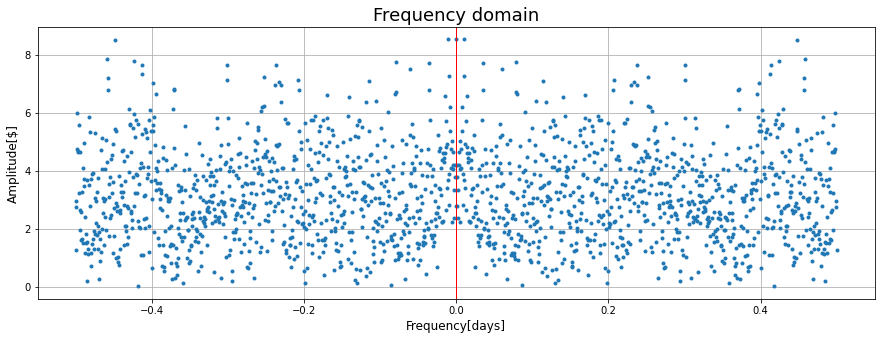

In [53]:
num_values = len(df)
half_num_values = num_values / 2
df['amplitude']=np.sqrt(sp.real**2 + sp.imag**2) / half_num_values
df['freq'] = np.fft.fftfreq(sp.size, d=1)
plt.figure(figsize=(15,5))
plt.plot(df['freq'],df['amplitude'].values,'.')
plt.axvline(x=0,ymin=0,ymax=1,linewidth=1,color='r')
plt.ylabel('Amplitude[$]', fontsize=12)
plt.xlabel('Frequency[days]', fontsize=12)
plt.title('Frequency domain', fontsize=18)
plt.grid()

In [43]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,fft_abs,fft_angle,delta,theta,amplitude,freq
0,2015-01-01,342.519877,346.064095,340.656844,344.068329,75660,0.0,0.0,4.491175e+06,0.000000,NaN,NaN,NaN,0.000000
1,2015-01-02,343.114633,346.064043,335.859081,338.567627,140430,0.0,0.0,1.650678e+06,1.274737,-5.500702,NaN,NaN,0.000577
2,2015-01-05,340.656813,346.064064,335.347882,337.682831,144620,0.0,0.0,8.756910e+05,1.115841,-0.884796,NaN,NaN,0.001153
3,2015-01-06,339.182145,342.623123,333.499616,336.807861,137810,0.0,0.0,8.379023e+05,1.184369,-0.874969,NaN,NaN,0.001730
4,2015-01-07,334.635115,345.862548,334.635115,343.665222,109470,0.0,0.0,7.085203e+05,1.620092,6.857361,NaN,NaN,0.002307


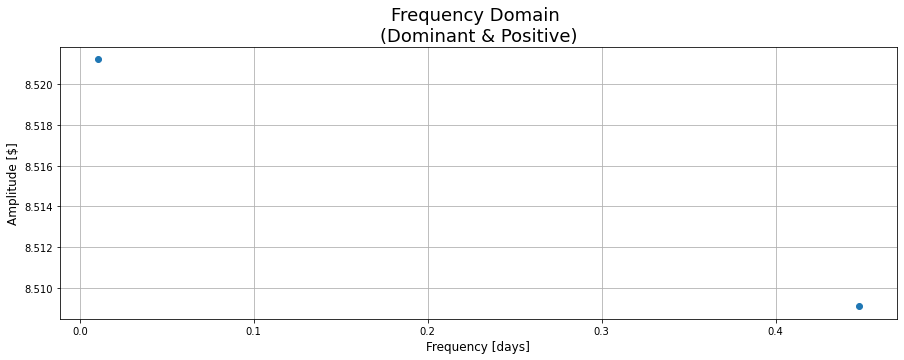

In [54]:
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (3*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']
plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid()

In [55]:
dominantFreq

Date
2015-01-29    0.010387
2018-02-23    0.447778
Name: freq, dtype: float64